### DELE Office Hour 10

**OBJECTIVES**

- Demonstrate `torchaudio` and its `StreamReader` functionality.
- Fine tune a pretrained model
- Build a simple GAN model
- Use pretrained gans from `torch.hub`

In [ ]:
import torch

In [ ]:
from torchaudio.io import StreamReader

In [ ]:
url = 'https://www.soundhelix.com/examples/mp3/SoundHelix-Song-1.mp3'

In [ ]:
from IPython.display import Audio

In [ ]:
Audio(url)

In [ ]:

reader = StreamReader(src = url)

In [ ]:
reader.get_src_stream_info(0)

SourceAudioStream(media_type='audio', codec='mp3', codec_long_name='MP3 (MPEG audio layer 3)', format='fltp', bit_rate=192000, num_frames=0, bits_per_sample=0, metadata={}, sample_rate=44100.0, num_channels=2)

In [ ]:
reader.num_src_streams

1

In [ ]:
reader.add_basic_audio_stream(
    frames_per_chunk=4000,
)

In [ ]:
for i in range(reader.num_out_streams):
  print(reader.get_out_stream_info(i))

OutputStream(source_index=0, filter_description='aformat=sample_fmts=fltp')


In [ ]:
n_ite = 1
waveforms = []
for chunk in reader.stream():
  waveforms.append(chunk)

In [ ]:
len(waveforms)

4110

In [ ]:
type(waveforms[0])

list

In [ ]:
len(waveforms[0])

1

In [ ]:
type(waveforms[0][0][0])

torch.Tensor

In [ ]:
len(waveforms[0])

1

(frames_per_chunk, num_channels)

In [ ]:
waveforms[0][0].shape

torch.Size([4000, 2])

In [ ]:
import matplotlib.pyplot as plt

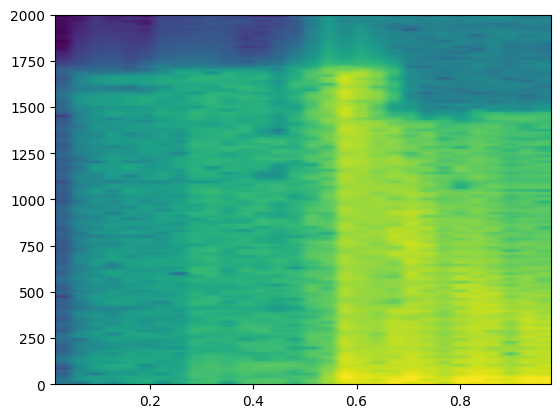

In [ ]:
plt.specgram(waveforms[0][0][:, 0], Fs = 4000);

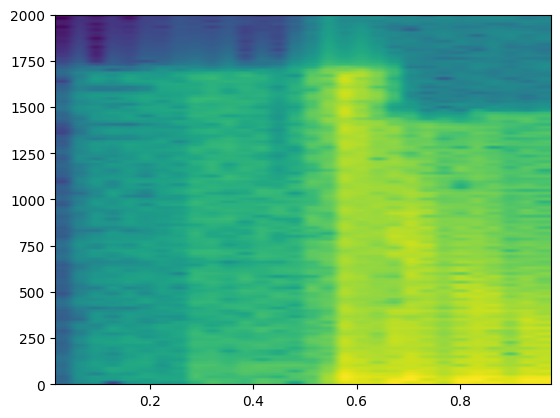

In [ ]:
plt.specgram(waveforms[0][0][:, 1], Fs = 4000);

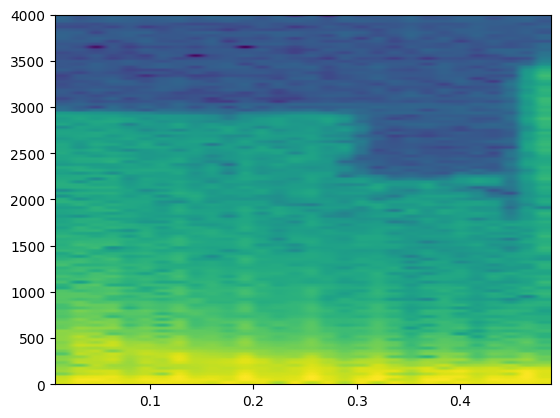

In [ ]:
plt.specgram(waveforms[1][0][:, 1], Fs = 8000);

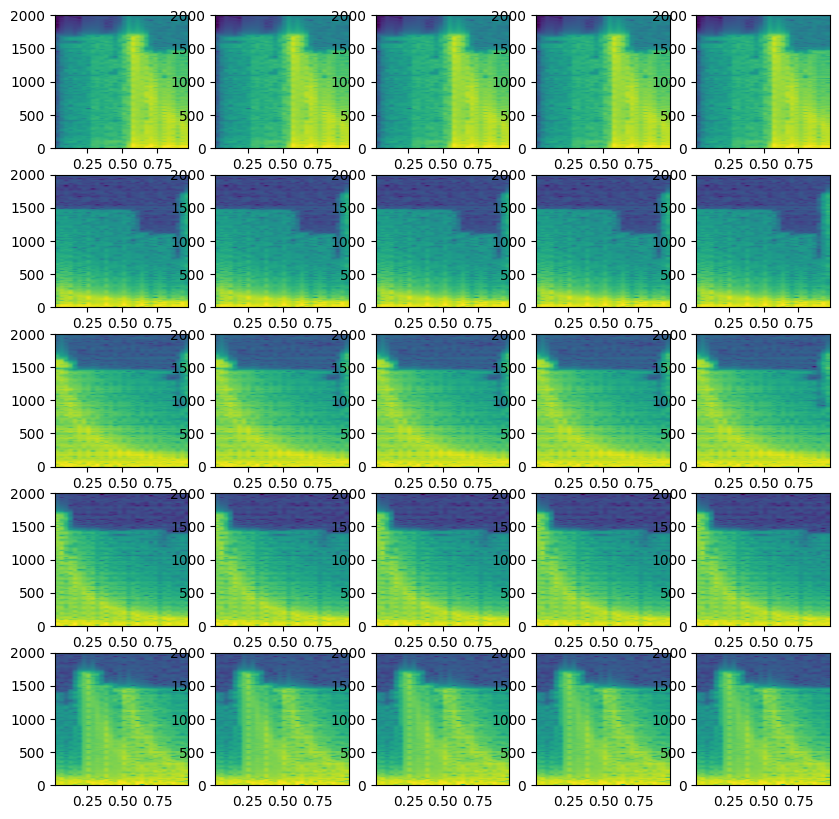

In [ ]:
fig, ax = plt.subplots(5, 5, figsize = (10, 10))
for i in range(5):
  for j in range(5):
    ax[i, j].specgram(waveforms[i][0][:, 0], Fs = 4000)

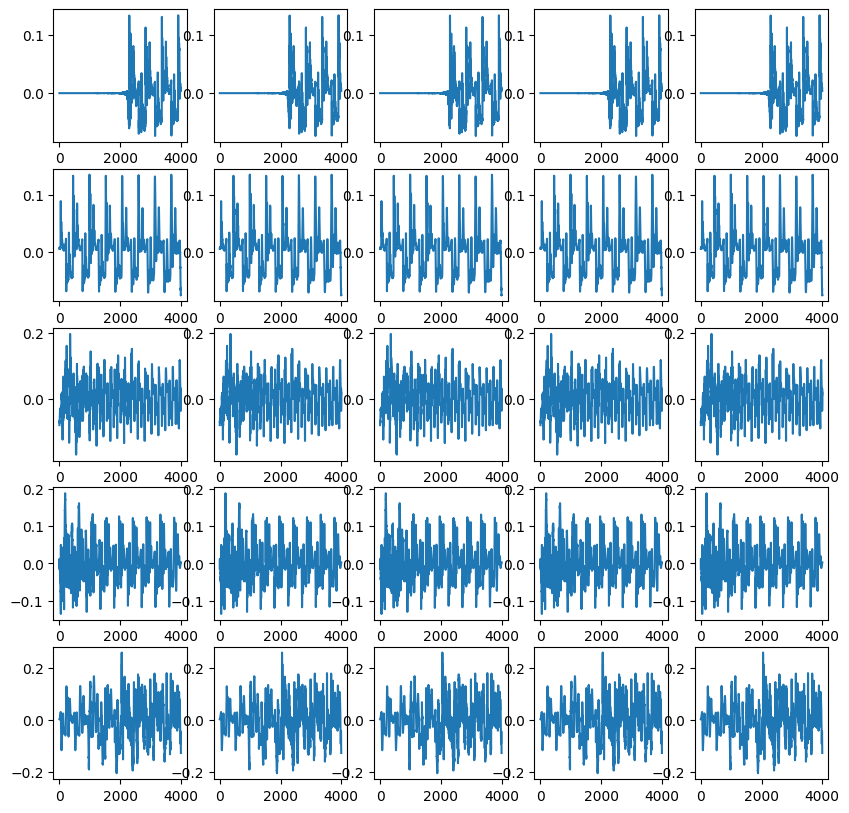

In [ ]:
fig, ax = plt.subplots(5, 5, figsize = (10, 10))
for i in range(5):
  for j in range(5):
    ax[i, j].plot(waveforms[i][0][:, 0])

### Fine Tuning a Model

In [ ]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

In [ ]:
train = CIFAR10(root = '.', download = True, transform=ToTensor())
test = CIFAR10(root = '.', download = True, train = False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12657587.86it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

In [ ]:
train_loader = DataLoader(train, batch_size=24)

In [ ]:
test_loader = DataLoader(test, batch_size = 24)

##### Fine - tuning a model



In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.3MB/s]


In [ ]:
num_ftrs

512

In [ ]:
device = 'cuda'

In [ ]:
model = model_ft.to(device)

In [ ]:
for epoch in range(5):
  #number correct tracking to print accuracy
  corrects = 0
  total = 0

  for x,y in train_loader:
    # print(x.dtype, y.dtype)
    x, y = x.to(device), y.to(device)
    yhat = model_ft(x)
    #actually making predictions in each batch
    _, preds = torch.max(yhat, 1)
    corrects += torch.sum(preds == y.data)
    total += len(y)
    loss = criterion(yhat, y)
    optimizer_ft.zero_grad()
    loss.backward()
    optimizer_ft.step()
  print(f'Epoch {epoch} with loss {loss.item(): .4f} and accuracy {corrects/total}')

Epoch 0 with loss  0.0016 and accuracy 0.9813999533653259
Epoch 1 with loss  0.0001 and accuracy 0.9852799773216248
Epoch 2 with loss  0.0057 and accuracy 0.9923200011253357
Epoch 3 with loss  0.0021 and accuracy 0.9927399754524231
Epoch 4 with loss  0.0849 and accuracy 0.9935399889945984


#### Feature Extraction (no training on pretrained parameters)

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False


num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(5):
  corrects = 0
  total = 0
  for x,y in train_loader:
    # print(x.dtype, y.dtype)
    x, y = x.to(device), y.to(device)
    yhat = model_conv(x)
    _, preds = torch.max(yhat, 1)
    corrects += torch.sum(preds == y.data)
    total += len(y)
    loss = criterion(yhat, y)
    optimizer_conv.zero_grad()
    loss.backward()
    optimizer_conv.step()
  print(f'Epoch {epoch} with loss {loss.item(): .4f} and accuracy {corrects/total}')

Epoch 0 with loss  3.0506 and accuracy 0.3802799880504608
Epoch 1 with loss  3.0563 and accuracy 0.4165000021457672
Epoch 2 with loss  3.0728 and accuracy 0.4221999943256378
Epoch 3 with loss  3.0885 and accuracy 0.4244000017642975
Epoch 4 with loss  3.1013 and accuracy 0.42583999037742615


Example from HuggingFace on Language models including transformers [here](https://huggingface.co/docs/transformers/training).

### Training a GAN

Simplified version of Sebastian Raschka's [here](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L18/04_01_gan-mnist.ipynb).

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=custom_transforms,
                               download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          num_workers=0,
                          shuffle=True)

In [ ]:
class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100,
                 image_height=28, image_width=28, color_channels=1):
        super().__init__()

        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels

        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, image_height*image_width*color_channels),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_height*image_width*color_channels, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1), # outputs logits
            #nn.Sigmoid()
        )

    def generator_forward(self, z):# z has dimension NCHW
        z = torch.flatten(z, start_dim=1)
        img = self.generator(z)
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        return img

    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

In [ ]:
model = GAN()
model.to(device)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=.0001)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=.0001)
loss_fn = F.binary_cross_entropy_with_logits

In [ ]:
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
log_dict = {'images_from_noise_per_epoch': []}
for epoch in range(2):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            # real images
            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device) # real label = 1

            # generated (fake) images
            noise = torch.randn(batch_size, 100, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optim_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()

            optim_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------

            optim_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optim_gen.step()
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                    torchvision.utils.make_grid(fake_images, padding=2, normalize=True))

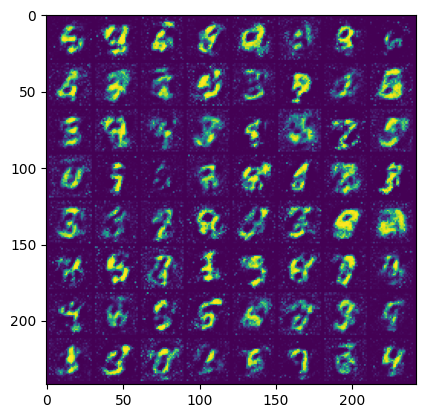

In [ ]:
plt.imshow(log_dict['images_from_noise_per_epoch'][0][0])

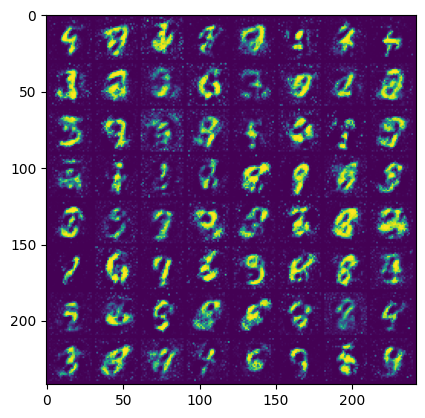

In [ ]:
plt.imshow(log_dict['images_from_noise_per_epoch'][-1][0])

In [ ]:
model = torch.hub.load('ndahlquist/pytorch-hub-stylegan:0.0.1', 'style_gan', pretrained=True)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ndahlquist/pytorch-hub-stylegan/zipball/0.0.1" to /root/.cache/torch/hub/0.0.1.zip
Downloading: "https://github.com/ndahlquist/lernapparat/releases/download/0.0.0/karras2019stylegan-ffhq-1024x1024.for_g_all-b418e00b3f4f99b879c3e805b8c55e.pt" to /root/.cache/torch/hub/checkpoints/karras2019stylegan-ffhq-1024x1024.for_g_a

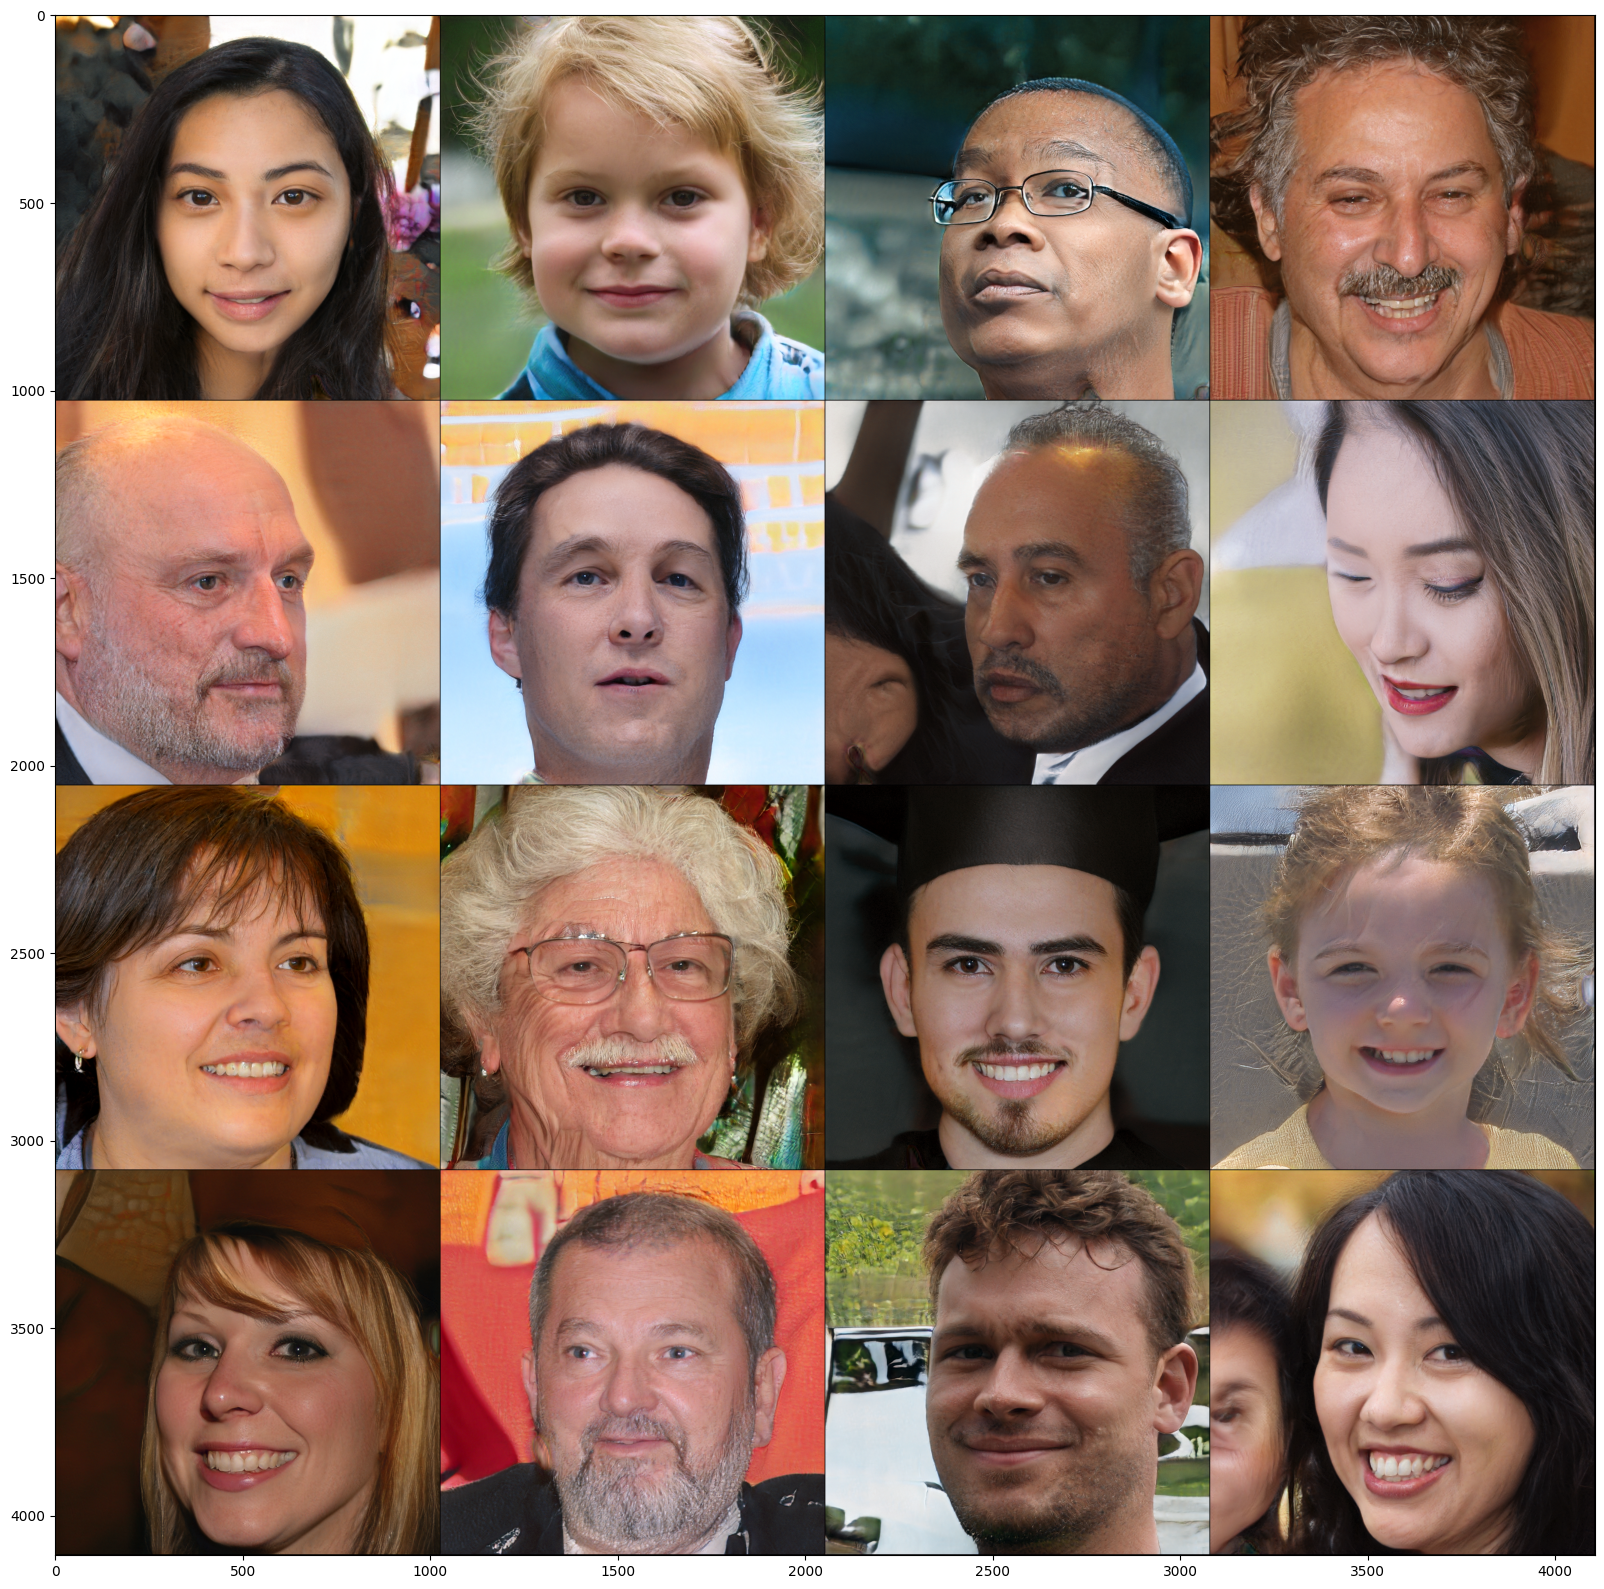

In [ ]:
model.eval()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)

nb_rows = 4
nb_cols = 4
nb_samples = nb_rows * nb_cols
latents = torch.randn(nb_samples, 512, device=device)
with torch.no_grad():
    imgs = model(latents)
    # normalization to 0..1 range
    imgs = (imgs.clamp(-1, 1) + 1) / 2.0
imgs = imgs.cpu()

imgs = torchvision.utils.make_grid(imgs, nrow=nb_cols)

plt.figure(figsize=(20, 20))
plt.imshow(imgs.permute(1, 2, 0).detach().numpy())